In [1]:
# standard data libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
import re
# math stuff
import numpy as np
import random
# plotting stuff
import matplotlib.cm as cm
# system stuff
from IPython.display import Image
import os
# plotting library
import plotly.figure_factory as ff
# set global variables and settings
sns.set_theme(style = 'darkgrid',
              palette='tab10',
             font_scale=1.5)
pd.options.display.max_colwidth = 200

# set directories
data_dir = os.path.join(os.getcwd(), "..", "raw_data")

# Read in Data & Clean Column Names

In [2]:
df = pd.read_csv(os.path.join(data_dir, "joined_depression_cre_walkability.csv"))
df.columns = [i.lower() for i in list(df.columns)]
rename_cols = {'location': 'census_tract_id',
                'indicator rate value': 'depressed_19_perc',
                 'locationname': 'census_tract_name',
                 'nh_black_alone_pe':'black_non_hisp_perc',
                 'nh_white_alone_pe':'white_non_hisp_perc',
                 'hispanic_pe':'hispanic_latino_perc',
                 'pred3_pe':'3_plus_cre_risk_factors_perc',
                 'blw_pov_lvl_pe':'below_poverty_level_perc',
                 'no_health_ins_pe':'no_health_insurance_perc',
                 'male_pe':'male_perc',
                 'female_pe':'female_perc',
                 'gini_ind_inequality_e':'income_inequality_gini_index',
                 'hs_grad_pe':'hs_grad_perc',
                 'no_veh_pe':'households_no_vehicle_perc',
                 'broadband_pe':'households_w_internet_perc',
                 'median_natwalkind':'walkability_score'
                }

clean_df = df.rename(rename_cols, axis='columns')
clean_df = clean_df[list(rename_cols.values())]
clean_df.head()

,census_tract_id,depressed_19_perc,census_tract_name,black_non_hisp_perc,white_non_hisp_perc,hispanic_latino_perc,3_plus_cre_risk_factors_perc,below_poverty_level_perc,no_health_insurance_perc,male_perc,female_perc,income_inequality_gini_index,hs_grad_perc,households_no_vehicle_perc,households_w_internet_perc,walkability_score
0,11001009907,21.1,11001009907,97.5,0.4,2.0,28.85,19.9,7.6,40.0,60.0,0.4280,88.6,54.3,64.4,12.250000
1,11001008802,18.3,11001008802,68.7,25.6,2.7,35.38,19.7,4.3,51.1,48.9,0.4983,86.0,34.2,72.8,13.500000
2,11001005900,22.1,11001005900,22.4,50.8,8.6,17.12,27.7,4.6,52.6,47.4,0.5047,90.7,61.1,82.6,16.500000
3,11001002900,19.3,11001002900,19.6,47.1,25.0,13.98,8.2,7.8,50.1,49.9,0.4526,85.6,38.2,88.4,16.166667
4,11001003302,18.5,11001003302,37.6,48.7,5.2,9.09,9.3,1.4,46.3,53.7,0.3496,97.3,12.4,89.9,15.750000


In [3]:
# clean data to make sure percents do not fall below 0 or over 100
for i in [i for i in list(clean_df.columns) if 'perc' in i]:
    print(i)
    clean_df[i] = clean_df[i].apply(lambda x: x if 0 < x < 100 else np.NaN)

depressed_19_perc
black_non_hisp_perc
white_non_hisp_perc
hispanic_latino_perc
3_plus_cre_risk_factors_perc
below_poverty_level_perc
no_health_insurance_perc
male_perc
female_perc
hs_grad_perc
households_no_vehicle_perc
households_w_internet_perc


# Create an indicator column for whether that census tract has > 50% Black population

In [4]:
cols_to_check = ['depressed_19_perc',
                'below_poverty_level_perc',
                'no_health_insurance_perc',
#                  'income_inequality_gini_index',
                 'hs_grad_perc',
                 'households_no_vehicle_perc',
                 'households_w_internet_perc',
                 'walkability_score'
                ]

clean_df['majority_black_population'] = clean_df['black_non_hisp_perc'] > 50
clean_df.majority_black_population.value_counts()

True     235
False    161
Name: majority_black_population, dtype: int64

In [24]:
majority_black_pop = clean_df[clean_df.majority_black_population].copy(deep=True)
non_majority_black_pop = clean_df[~clean_df.majority_black_population].copy(deep=True)
print(len(clean_df))
print(len(majority_black_pop)) 
print(len(non_majority_black_pop))

396
235
161


In [79]:
print("Avg. for non-Black Tracts = Average value across census tracts w/ < 50% Black population within D.C. and P.G. County")
print("Avg. for maj. Black Tracts = Average value across census tracts that have >= 50% Black population within D.C. and P.G. County")
print("--------------------------------------------------------")
avg_nonblack_tracts = []
avg_black_tracts = []
for i in cols_to_check:
    print(i)
    print("\tAvg. for < 50% Black:", non_majority_black_pop[i].mean())
    print("\tAvg. for >= 50% Black:", majority_black_pop[i].mean())
    avg_nonblack_tracts.append(non_majority_black_pop[i].mean())
    avg_black_tracts.append(majority_black_pop[i].mean())
comparing_avgs = pd.DataFrame({'Measure':cols_to_check,
                              'Avg. for <50% Black Census Tracts':avg_nonblack_tracts,
                              'Avg. for >=50% Black Census Tracts':avg_black_tracts})

print("--------------------------------------------------------")    
print("--- Top 5 Census Tracts with Highest Values for Each Measure---")
print("Google Census Tract ID to Find Location")
for i in cols_to_check:
    print(majority_black_pop.sort_values(by=i, ascending=False)[['census_tract_name', i]].head(5).to_string(index=False))

Avg. for non-Black Tracts = Average value across census tracts w/ < 50% Black population within D.C. and P.G. County
Avg. for maj. Black Tracts = Average value across census tracts that have >= 50% Black population within D.C. and P.G. County
--------------------------------------------------------
depressed_19_perc
	Avg. for < 50% Black: 17.703105590062115
	Avg. for >= 50% Black: 15.317446808510638
below_poverty_level_perc
	Avg. for < 50% Black: 10.588198757763978
	Avg. for >= 50% Black: 13.683829787234032
no_health_insurance_perc
	Avg. for < 50% Black: 8.122151898734176
	Avg. for >= 50% Black: 6.6838297872340435
hs_grad_perc
	Avg. for < 50% Black: 87.05256410256412
	Avg. for >= 50% Black: 88.74765957446812
households_no_vehicle_perc
	Avg. for < 50% Black: 23.542500000000015
	Avg. for >= 50% Black: 19.06577777777777
households_w_internet_perc
	Avg. for < 50% Black: 87.7949685534591
	Avg. for >= 50% Black: 81.54401709401705
walkability_score
	Avg. for < 50% Black: 14.111801242313662
	A

In [80]:
comparing_avgs

,Measure,Avg. for <50% Black Census Tracts,Avg. for >=50% Black Census Tracts
0,depressed_19_perc,17.703106,15.317447
1,below_poverty_level_perc,10.588199,13.683830
2,no_health_insurance_perc,8.122152,6.683830
3,hs_grad_perc,87.052564,88.747660
4,households_no_vehicle_perc,23.542500,19.065778
5,households_w_internet_perc,87.794969,81.544017
6,walkability_score,14.111801,11.590426


Text(0.5, 0, 'Risk Factor')

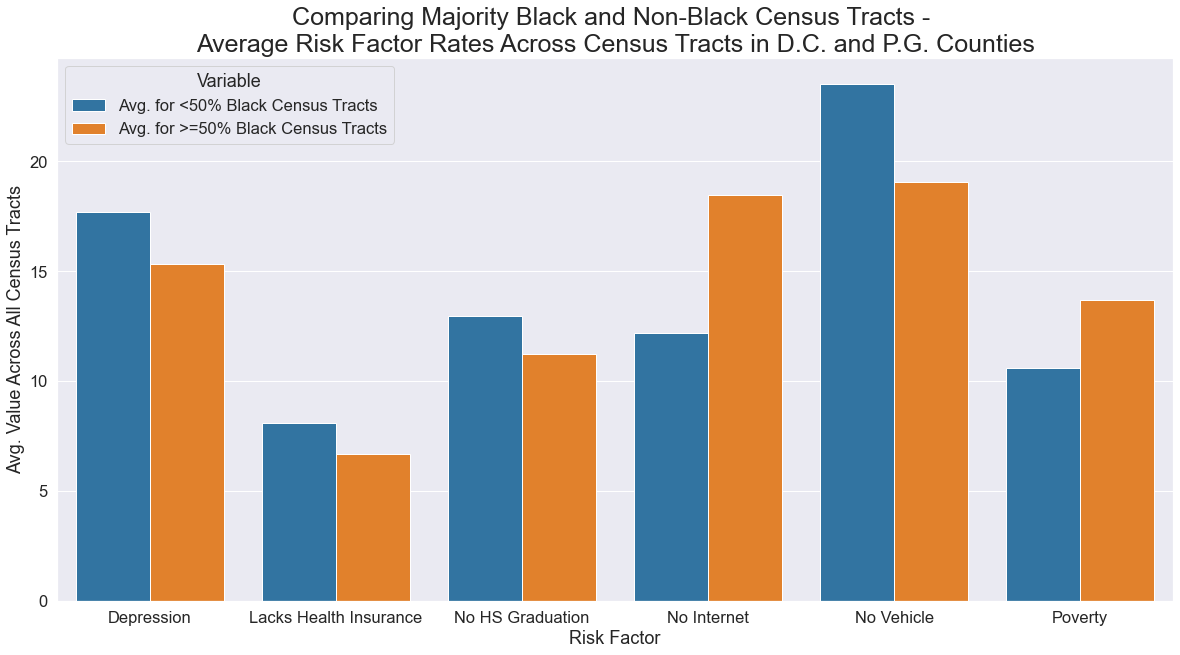

In [97]:
tidy = comparing_avgs.melt(id_vars='Measure').rename(columns=str.title)
change_names = {'depressed_19_perc':'Depression',
                'below_poverty_level_perc':'Poverty',
                'no_health_insurance_perc':'Lacks Health Insurance',
                'hs_grad_perc':'No HS Graduation',
                'households_no_vehicle_perc':'No Vehicle',
                'households_w_internet_perc':'No Internet'
               }
tidy['Measure'] = tidy['Measure'].map(change_names)
tidy = tidy[~tidy['Measure'].isna()].copy(deep=True)
tidy.loc[tidy['Measure'].apply(lambda x: x in ['No Internet', 'No HS Graduation']), 'Value'] = 100-tidy['Value']
tidy = tidy.sort_values(by="Measure")

fig, ax1 = plt.subplots(ncols=1, figsize=(20,10))
sns.barplot(data = tidy,
            x = 'Measure',
            y = 'Value',
            hue = 'Variable',
            ax = ax1
           )
ax1.set_title("Comparing Majority Black and Non-Black Census Tracts - \nAverage Risk Factor Rates Across Census Tracts in D.C. and P.G. Counties",
             fontsize=25)
ax1.set_ylabel("Avg. Value Across All Census Tracts")
ax1.set_xlabel("Risk Factor")


# Display Plots Showing Data Distribution for Each Measure

In [45]:
# create these lists so that we can show the different distributions for ALL census tracts
# and those with a majority black population
cols = ['black', 'blue']
dataframes = [non_majority_black_pop, majority_black_pop]

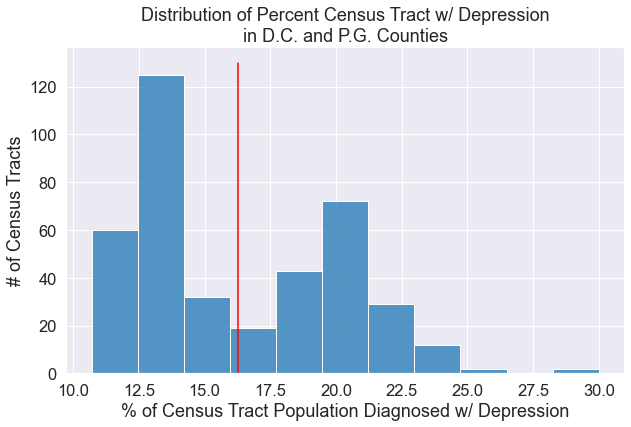

In [50]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
             x = 'depressed_19_perc')
ax1.set_title("Distribution of Percent Census Tract w/ Depression\nin D.C. and P.G. Counties")
ax1.set_xlabel("% of Census Tract Population Diagnosed w/ Depression")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.depressed_19_perc.mean(), clean_df.depressed_19_perc.mean()], # where the vertical line should be plotted
         [0, 130], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

In 2019, the average Black population within a D.C. or P.G. county census tract was 56%.


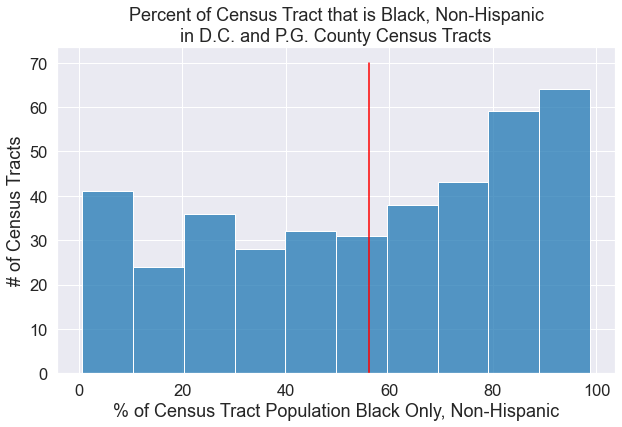

In [52]:
print(f"In 2019, the average Black population within a D.C. or P.G. county census tract was {int(clean_df.black_non_hisp_perc.mean())}%.")

# print(clean_df.black_non_hisp_perc.isna().sum())

fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))

sns.histplot(data = clean_df,
            x = 'black_non_hisp_perc')
ax1.set_title("Percent of Census Tract that is Black, Non-Hispanic\nin D.C. and P.G. County Census Tracts")
ax1.set_xlabel("% of Census Tract Population Black Only, Non-Hispanic")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.black_non_hisp_perc.mean(), clean_df.black_non_hisp_perc.mean()], # where the vertical line should be plotted
         [0, 70], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

In 2019, the average poverty rate within a D.C. or P.G. County census tract was 12%.


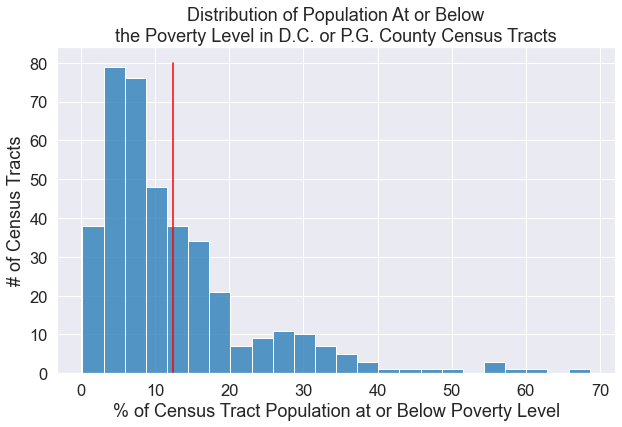

In [9]:
print(f"In 2019, the average poverty rate within a D.C. or P.G. County census tract was {int(clean_df.below_poverty_level_perc.mean())}%.")


# print(clean_df.below_poverty_level_perc.isna().sum())

fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'below_poverty_level_perc')
ax1.set_title("Distribution of Population At or Below\nthe Poverty Level in D.C. or P.G. County Census Tracts")
ax1.set_xlabel("% of Census Tract Population at or Below Poverty Level")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.below_poverty_level_perc.mean(), clean_df.below_poverty_level_perc.mean()], # where the vertical line should be plotted
         [0, 80], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

In 2019, the average rate of households without health insurance within a D.C. or P.G. County census tract was 7%.
The 5 D.C. census tracts with the highest rates of households without health insurance were
 census_tract_name  no_health_insurance_perc
       24033805602                      56.1
       24033805601                      55.1
       24033803900                      35.4
       24033806501                      33.1
       24033806601                      32.8


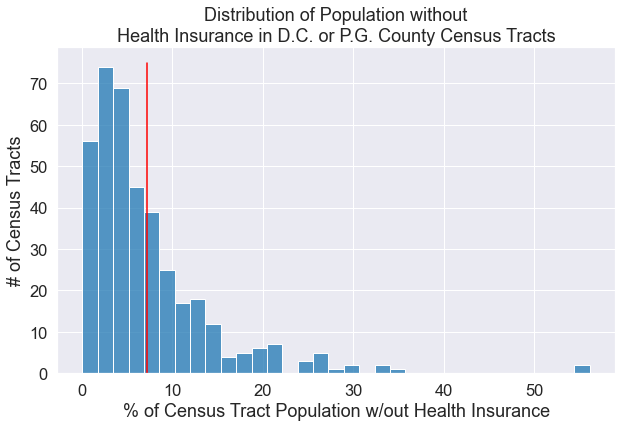

In [10]:
print(f"In 2019, the average rate of households without health insurance within a D.C. or P.G. County census tract was {int(clean_df.no_health_insurance_perc.mean())}%.")
print(f"The 5 D.C. census tracts with the highest rates of households without health insurance were")
print(clean_df.sort_values(by='no_health_insurance_perc', ascending=False)[['census_tract_name', 'no_health_insurance_perc']].head(5).to_string(index=False))
# print(clean_df.sort_values(by='households_no_vehicle_perc', ascending=False)['census_tract_name'].apply(lambda x: x[:x.index(',')]).head(5).to_string(index=False))

# print(clean_df.no_health_insurance_perc.isna().sum())

fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'no_health_insurance_perc')
ax1.set_title("Distribution of Population without\nHealth Insurance in D.C. or P.G. County Census Tracts")
ax1.set_xlabel("% of Census Tract Population w/out Health Insurance")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.no_health_insurance_perc.mean(), clean_df.no_health_insurance_perc.mean()], # where the vertical line should be plotted
         [0, 75], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

In 2019, on average 20% of households within a D.C. or P.G. County tract did not own a car.
The 5 D.C. tracts with the highest percentage of households without a car were:


,census_tract_name,households_no_vehicle_perc
27,11001010800,83.0
21,11001007401,66.3
76,11001006400,63.7
70,11001010700,62.4
172,11001007708,61.5


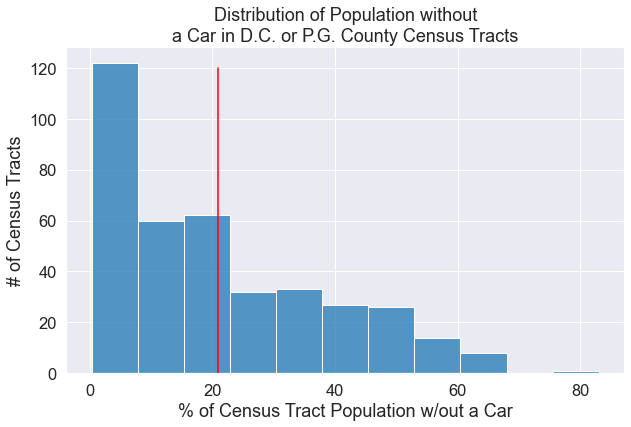

In [11]:
# print(clean_df.households_no_vehicle_perc.isna().sum())
print(f"In 2019, on average {int(clean_df.households_no_vehicle_perc.mean())}% of households within a D.C. or P.G. County tract did not own a car.")
print(f"The 5 D.C. tracts with the highest percentage of households without a car were:")


fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'households_no_vehicle_perc')
ax1.set_title("Distribution of Population without\na Car in D.C. or P.G. County Census Tracts")
ax1.set_xlabel("% of Census Tract Population w/out a Car")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.households_no_vehicle_perc.mean(), clean_df.households_no_vehicle_perc.mean()], # where the vertical line should be plotted
         [0, 120], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

clean_df.sort_values(by='households_no_vehicle_perc', ascending=False)[['census_tract_name', 'households_no_vehicle_perc']].head(5)

0


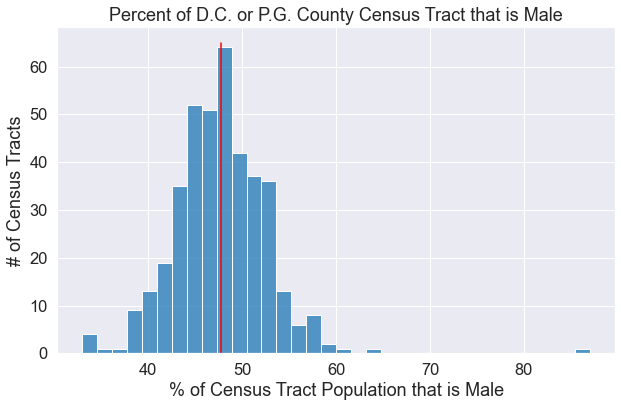

In [12]:
print(clean_df.male_perc.isna().sum())

fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'male_perc')
ax1.set_title("Percent of D.C. or P.G. County Census Tract that is Male")
ax1.set_xlabel("% of Census Tract Population that is Male")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.male_perc.mean(), clean_df.male_perc.mean()], # where the vertical line should be plotted
         [0, 65], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

In [13]:
# fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
# sns.histplot(data = clean_df,
#             x = 'income_inequality_gini_index')
# ax1.set_title("Income Inequality Gini Index in D.C. and P.G. County")
# ax1.set_xlabel("Income Inequality Gini Index within a Census Tract")
# ax1.set_ylabel("# of Census Tracts")

# plt.plot([clean_df.income_inequality_gini_index.mean(), clean_df.income_inequality_gini_index.mean()], # where the vertical line should be plotted
#          [0, 65], # the y min and y max - the y max should be the max value counts for that plot
#          color='red')

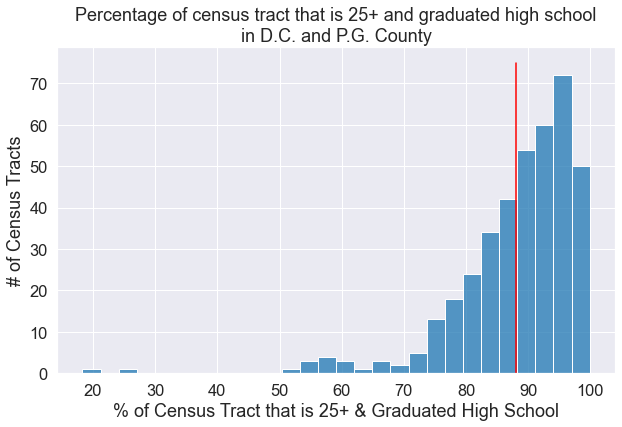

In [14]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'hs_grad_perc')
ax1.set_title("Percentage of census tract that is 25+ and graduated high school\nin D.C. and P.G. County")
ax1.set_xlabel("% of Census Tract that is 25+ & Graduated High School")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.hs_grad_perc.mean(), clean_df.hs_grad_perc.mean()], # where the vertical line should be plotted
         [0, 75], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

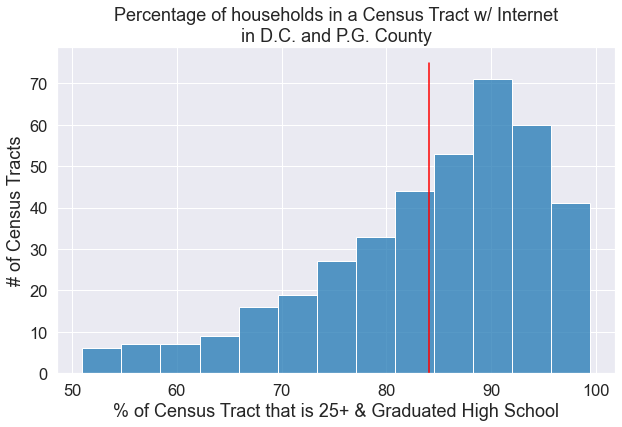

In [15]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'households_w_internet_perc')
ax1.set_title("Percentage of households in a Census Tract w/ Internet\nin D.C. and P.G. County")
ax1.set_xlabel("% of Census Tract that is 25+ & Graduated High School")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.households_w_internet_perc.mean(), clean_df.households_w_internet_perc.mean()], # where the vertical line should be plotted
         [0, 75], # the y min and y max - the y max should be the max value counts for that plot
         color='red')

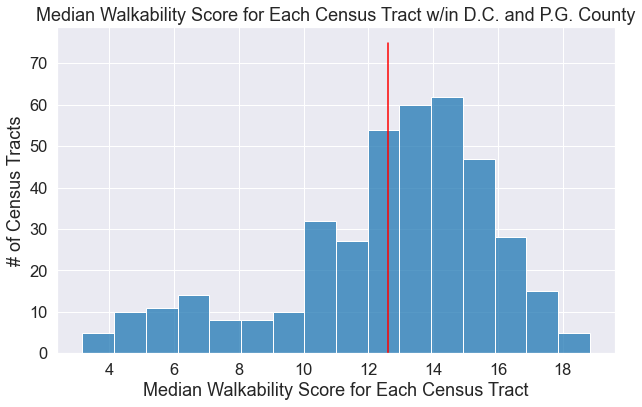

In [16]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,6))
sns.histplot(data = clean_df,
            x = 'walkability_score')
ax1.set_title("Median Walkability Score for Each Census Tract w/in D.C. and P.G. County")
ax1.set_xlabel("Median Walkability Score for Each Census Tract")
ax1.set_ylabel("# of Census Tracts")

plt.plot([clean_df.walkability_score.mean(), clean_df.walkability_score.mean()], # where the vertical line should be plotted
         [0, 75], # the y min and y max - the y max should be the max value counts for that plot
         color='red')